In [15]:
import sys
sys.version

'3.9.6 (default, Aug 18 2021, 15:44:49) [MSC v.1916 64 bit (AMD64)]'

In [70]:
import os
import json
import pandas as pd
import numpy as np
import contractions
import unicodedata
import re
import spacy
import en_core_web_lg
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
#nltk.download('stopwords')

In [23]:
# Run once
os.chdir('..')
os.chdir('..')

In [28]:
pwd

'D:\\springboard\\capstone'

### Read data

In [103]:
# Read data
sent_original = pd.read_csv('data/sentiment/all-data.csv', encoding = "ISO-8859-1", header=None)
sent = sent_original.copy()

In [104]:
sent.columns = ['sent', 'headline']

In [105]:
sent.shape

(4846, 2)

In [106]:
sent.head()

,sent,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


### Expand contractions

There are contractions! Not many, but still...

In [107]:
sent['headline'] = sent.headline.str.replace(" '", "'")
sent['headline'] = sent.headline.str.replace(" n't", "n't")
sent['headline'] = sent.headline.map(lambda x: contractions.fix(x))

In [112]:
sent['headline'] = sent.headline.str.replace("'s ", " ")

In [113]:
sent.head()

,sent,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company updated strategy for ...


### Removing accents

In [114]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

In [115]:
sent['headline'] = sent.headline.map(lambda x: remove_accented_chars(x))

In [116]:
sent.head()

,sent,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company updated strategy for ...


### Remove special characters

In [117]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@! 3.2%", 
                          remove_digits=True)

'Well this was fun What do you think  '

In [118]:
sent['headline'] = sent.headline.map(lambda x: remove_special_characters(x, remove_digits=True))

In [119]:
sent.head()

,sent,headline
0,neutral,According to Gran the company has no plans to...
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company updated strategy for ...


### Lemmatize

In [ ]:
# In command prompt
# python -m spacy download en

In [120]:
nlp = en_core_web_lg.load()

In [121]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday , ours crash daily'

In [122]:
sent['headline'] = sent.headline.map(lambda x: lemmatize_text(x))

In [123]:
sent.head()

,sent,headline
0,neutral,accord to Gran the company have no plan to m...
1,neutral,Technopolis plan to develop in stage an area o...
2,negative,the international electronic industry company ...
3,positive,with the new production plant the company woul...
4,positive,accord to the company update strategy for the ...


In [124]:
sent_original.loc[4, 1]

"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales ."

In [125]:
sent.headline[4]

'accord to the company update strategy for the year    Basware target a longterm net sale growth in the range of      with an operating profit margin of      of net sale'

### Remove stop words

In [126]:
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [127]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [128]:
sent['headline'] = sent.headline.map(lambda x: remove_stopwords(x))

In [129]:
sent.head()

,sent,headline
0,neutral,accord Gran company no plan move production Ru...
1,neutral,Technopolis plan develop stage area no less sq...
2,negative,international electronic industry company Elco...
3,positive,new production plant company would increase ca...
4,positive,accord company update strategy year Basware ta...


In [130]:
sent_original.loc[4, 1]

"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales ."

In [131]:
sent.headline[4]

'accord company update strategy year Basware target longterm net sale growth range operating profit margin net sale'

### Sequence encoding

In [203]:
num_words = 2000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

In [212]:
# Tokenize our training data
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(sent.headline)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(sent.headline)

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
maxlen = 25

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Output the results of our work
#print("Word index:\n", word_index)
#print("\nTraining sequences:\n", train_sequences)
#print("\nPadded training sequences:\n", train_padded)
#print("\nPadded training shape:", train_padded.shape)
#print("Training sequences data type:", type(train_sequences))
#print("Padded Training sequences data type:", type(train_padded))

In [213]:
import matplotlib.pyplot as plt

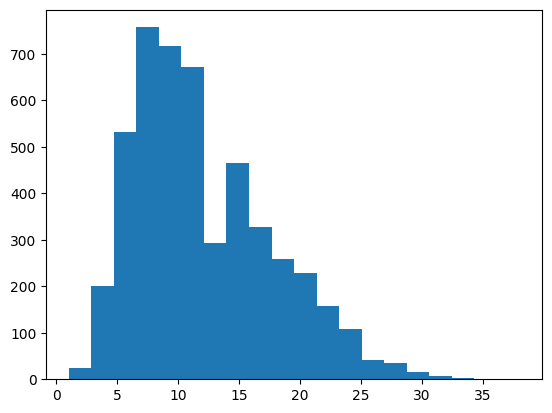

In [214]:
plt.hist([len(x) for x in train_sequences], bins=20)
plt.show()

In [215]:
target = sent.sent.map({'positive': 1, 'neutral': 0, 'negative': -1})

In [216]:
df = pd.concat((target, pd.DataFrame(train_padded)), axis=1)
df

,sent,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,59,1,3,178,74,352,52,95,1,...,0,0,0,0,0,0,0,0,0,0
1,0,655,74,94,922,82,178,923,498,1272,...,924,445,4,0,0,0,0,0,0,0
2,-1,214,154,75,3,273,460,757,97,925,...,1,140,758,687,1,39,0,0,0,0
3,1,19,52,40,3,83,25,184,688,49,...,204,1273,25,52,926,0,0,0,0,0
4,1,59,3,1004,282,13,227,166,427,10,...,10,7,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4841,-1,578,1,9,67,89,559,578,612,1,...,1168,0,0,0,0,0,0,0,0,0
4842,0,1,403,7,121,54,291,8,1175,1,...,8,1175,0,0,0,0,0,0,0,0
4843,-1,27,11,121,2,5,2,5,28,584,...,0,0,0,0,0,0,0,0,0,0
4844,-1,10,7,86,371,90,2,5,102,22,...,459,685,342,60,2,5,2,5,0,0


In [217]:
pwd

'D:\\springboard\\capstone'

In [218]:
df.to_csv('data/sentiment/data_clean.csv', index=False)

In [221]:
with open("data/sentiment/word_index.json", "w") as outfile:
    json.dump(word_index, outfile)

### Validation

In [222]:
word_index_inv = {v: k for k, v in word_index.items()}

In [229]:
i = 2

In [230]:
sent_original.loc[i, 1]

'The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .'

In [231]:
sent.loc[i, 'headline']

'international electronic industry company Elcoteq lay ten employee Tallinn facility contrary early layoff company contract rank office worker daily Postimees report'

In [232]:
pd.DataFrame(df.loc[i][0:]).T

,sent,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
2,-1,214,154,75,3,273,460,757,97,925,...,1,140,758,687,1,39,0,0,0,0


In [233]:
' '.join(list(df.loc[i][1:].map(word_index_inv).dropna()))

'international electronic industry company elcoteq lay ten employee tallinn facility <UNK> early layoff company contract <UNK> office worker daily <UNK> report'

### References

A Practitioner's Guide to Natural Language Processing (Part I) — Processing & Understanding Text  
https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

NLP – Expand contractions in Text Processing  
https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/

Text Normalization for Natural Language Processing (NLP)  
https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646

A hands-on intuitive approach to Deep Learning Methods for Text Data — Word2Vec, GloVe and FastText  
https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa

Tokenization and Text Data Preparation with TensorFlow & Keras  
https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html